# Variational Autoencoder
Build a variational autoencoder to work on fashion-MNIST data set. "Hands-On Machine Learning", by Aurelien Geron, is the basis for much of the code. https://github.com/ageron/handson-ml2

In [1]:
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorboard

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

%matplotlib inline

TensorFlow version:  2.0.0
Keras version:  2.2.4-tf
Tensorboard version: 2.0.0


## 1.0 Load and Prepare Data

In [4]:
# load fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
(X_train_all, y_train_all), (X_test, y_test) = fashion_mnist.load_data()

In [5]:
# check the shape of the data sets
print('X_train_full shape:', X_train_all.shape)
print('y_train_full shape:', y_train_all.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train_full shape: (60000, 28, 28)
y_train_full shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [6]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [7]:
# split the data between train and validation sets, and scale

X_valid, X_train = X_train_all[:5000] / 255.0, X_train_all[5000:] / 255.0
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

# also scale the X_test
X_test = X_test / 255.0

print('X_valid shape:', X_valid.shape)
print('y_valid shape:', y_valid.shape)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_valid shape: (5000, 28, 28)
y_valid shape: (5000,)
X_train shape: (55000, 28, 28)
y_train shape: (55000,)


## 2.0 Variational Autoencoder
Build the variational autoencoder. First, we will create a custom function to sample the mean and log-variables.

In [11]:
# build custom sampling function
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [12]:
# rounded accuracy for the metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

variational_encoder.summary()
variational_decoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 150)          117750      flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          15100       dense_4[0][0]                    
______________________________________________________________________________________________

In [14]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 67us/sample - loss: 0.3909 - rounded_accuracy: 0.8598 - val_loss: 0.3506 - val_rounded_accuracy: 0.8850
Epoch 2/25
55000/55000 [==============================] - 2s 38us/sample - loss: 0.3426 - rounded_accuracy: 0.8981 - val_loss: 0.3317 - val_rounded_accuracy: 0.9070
Epoch 3/25
55000/55000 [==============================] - 2s 38us/sample - loss: 0.3328 - rounded_accuracy: 0.9054 - val_loss: 0.3293 - val_rounded_accuracy: 0.9044
Epoch 4/25
55000/55000 [==============================] - 2s 38us/sample - loss: 0.3279 - rounded_accuracy: 0.9091 - val_loss: 0.3217 - val_rounded_accuracy: 0.9137
Epoch 5/25
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3247 - rounded_accuracy: 0.9120 - val_loss: 0.3226 - val_rounded_accuracy: 0.9111
Epoch 6/25
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3225 - rounded_accuracy: 0.9136 - val_loss:

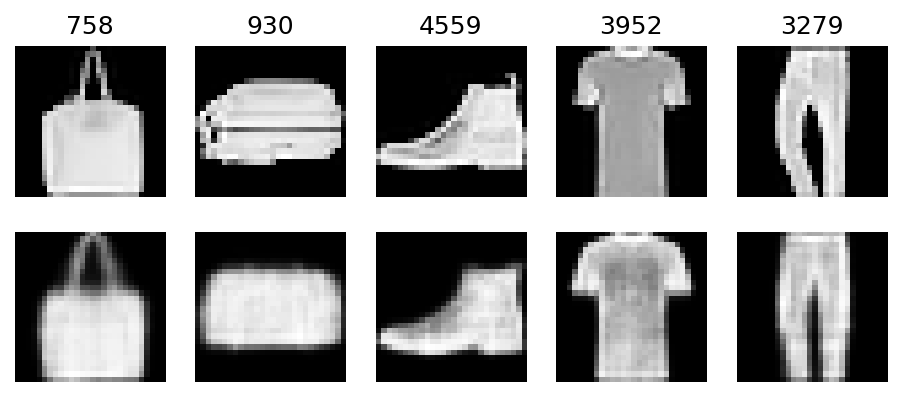

In [15]:
# plot the results
def plot_reconstructions(model, index_list, X_valid): 
    reconstructions = model.predict(X_valid)
    
    # get the length of index_list to set number of
    # images to plot
    n_images = len(index_list)

    # Plot a random sample
    fig, axes = plt.subplots(2, n_images,figsize=(n_images*1.5,3),dpi=150)
    # fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

    for i in range(0, n_images):
        axes[0][i].imshow(np.reshape(X_valid[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[0][i].axis('off')
        axes[0][i].set_title(str(index_list[i]))
        axes[1][i].imshow(np.reshape(reconstructions[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[1][i].axis('off')
        
    plt.show()

import random
index_list = random.sample(range(0,len(X_valid)), 5)
plot_reconstructions(variational_ae, index_list, X_valid)